# Exercise 3.5 - Simple Classification using TensorFlow

1. Import all required modules and print version of the most important ones: 

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

from  IPython import display
from matplotlib import pyplot as plt
from scipy.ndimage.filters import gaussian_filter1d
import pandas as pd
import numpy as np

import tensorflow as tf
import tensorflow_datasets as tfds

print("TensorFlow version: {}".format(tf.__version__)) 
print("TensorFlow datasets version: {}".format(tfds.__version__))

TensorFlow version: 2.1.0
TensorFlow datasets version: 2.1.0


2. Dataset import and data preparation
    
    a) Print TensorFlow datasets list

In [2]:
# See available datasets
print(tfds.list_builders())

['abstract_reasoning', 'aeslc', 'aflw2k3d', 'amazon_us_reviews', 'arc', 'bair_robot_pushing_small', 'beans', 'big_patent', 'bigearthnet', 'billsum', 'binarized_mnist', 'binary_alpha_digits', 'c4', 'caltech101', 'caltech_birds2010', 'caltech_birds2011', 'cars196', 'cassava', 'cats_vs_dogs', 'celeb_a', 'celeb_a_hq', 'cfq', 'chexpert', 'cifar10', 'cifar100', 'cifar10_1', 'cifar10_corrupted', 'citrus_leaves', 'cityscapes', 'civil_comments', 'clevr', 'cmaterdb', 'cnn_dailymail', 'coco', 'coil100', 'colorectal_histology', 'colorectal_histology_large', 'cos_e', 'curated_breast_imaging_ddsm', 'cycle_gan', 'deep_weeds', 'definite_pronoun_resolution', 'diabetic_retinopathy_detection', 'div2k', 'dmlab', 'downsampled_imagenet', 'dsprites', 'dtd', 'duke_ultrasound', 'dummy_dataset_shared_generator', 'dummy_mnist', 'emnist', 'eraser_multi_rc', 'esnli', 'eurosat', 'fashion_mnist', 'flic', 'flores', 'food101', 'gap', 'gigaword', 'glue', 'groove', 'higgs', 'horses_or_humans', 'i_naturalist2017', 'image

    b) Print Higgs dataset info to familiarize with it

In [3]:
higgs_ds_builder = tfds.builder("higgs")
higgs_info = higgs_ds_builder.info
print(higgs_info)

tfds.core.DatasetInfo(
    name='higgs',
    version=2.0.0,
    description='The data has been produced using Monte Carlo simulations. 
The first 21 features (columns 2-22) are kinematic properties 
measured by the particle detectors in the accelerator. 
The last seven features are functions of the first 21 features; 
these are high-level features derived by physicists to help 
discriminate between the two classes. There is an interest 
in using deep learning methods to obviate the need for physicists 
to manually develop such features. Benchmark results using 
Bayesian Decision Trees from a standard physics package and 
5-layer neural networks are presented in the original paper. 
',
    homepage='https://archive.ics.uci.edu/ml/datasets/HIGGS',
    features=FeaturesDict({
        'class_label': tf.float32,
        'jet_1_b-tag': tf.float64,
        'jet_1_eta': tf.float64,
        'jet_1_phi': tf.float64,
        'jet_1_pt': tf.float64,
        'jet_2_b-tag': tf.float64,
        'jet_

    c) Download custom smaller subset of the original dataset

In [4]:
higgs_path = tf.keras.utils.get_file('HIGGSSmall.csv.gz', 'https://github.com/PacktWorkshops/The-Reinforcement-Learning-Workshop/blob/master/Chapter03/HIGGSSmall.csv.gz?raw=true')

    d) Read CSV dataset into TensorFlow Dataset class and repack it to have tuples (features, labels)

In [5]:
N_TEST = int(1e3)
N_VALIDATION = int(1e3)
N_TRAIN = int(1e4)
BUFFER_SIZE = int(N_TRAIN)
BATCH_SIZE = 500
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

N_FEATURES = 28

ds = tf.data.experimental.CsvDataset(higgs_path,[float(),]*(N_FEATURES+1), compression_type="GZIP")

def pack_row(*row):
    label = row[0]
    features = tf.stack(row[1:],1)
    return features, label

packed_ds = ds.batch(N_TRAIN).map(pack_row).unbatch()

    e) Take a look at features value distribution

tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)


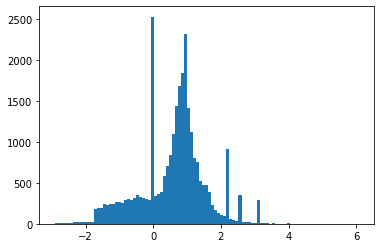

In [6]:
for features,label in packed_ds.batch(1000).take(1):
    print(features[0])
    plt.hist(features.numpy().flatten(), bins = 101)

    f) Create training, validation and test sets

In [7]:
validate_ds = packed_ds.take(N_VALIDATION).cache()
test_ds = packed_ds.skip(N_VALIDATION).take(N_TEST).cache()
train_ds = packed_ds.skip(N_VALIDATION+N_TEST).take(N_TRAIN).cache()

    g) Define features, label and class names

In [8]:
feature_names = ["lepton pT", "lepton eta", "lepton phi", "missing energy magnitude", "missing energy phi",
                 "jet 1 pt", "jet 1 eta", "jet 1 phi", "jet 1 b-tag", "jet 2 pt", "jet 2 eta", "jet 2 phi", 
                 "jet 2 b-tag", "jet 3 pt", "jet 3 eta", "jet 3 phi", "jet 3 b-tag", "jet 4 pt", "jet 4 eta", 
                 "jet 4 phi", "jet 4 b-tag", "m_jj", "m_jjj", "m_lv", "m_jlv", "m_bb", "m_wbb", "m_wwbb"]
label_name = ['Measure']
class_names = ['Signal', 'Background']

print("Features: {}".format(feature_names))
print("Label: {}".format(label_name))
print("Class names: {}".format(class_names))

Features: ['lepton pT', 'lepton eta', 'lepton phi', 'missing energy magnitude', 'missing energy phi', 'jet 1 pt', 'jet 1 eta', 'jet 1 phi', 'jet 1 b-tag', 'jet 2 pt', 'jet 2 eta', 'jet 2 phi', 'jet 2 b-tag', 'jet 3 pt', 'jet 3 eta', 'jet 3 phi', 'jet 3 b-tag', 'jet 4 pt', 'jet 4 eta', 'jet 4 phi', 'jet 4 b-tag', 'm_jj', 'm_jjj', 'm_lv', 'm_jlv', 'm_bb', 'm_wbb', 'm_wwbb']
Label: ['Measure']
Class names: ['Signal', 'Background']


    h) Show a sample of a training instance features and label

In [9]:
features, labels = next(iter(train_ds))
print("Features =")
print(features.numpy())
print("Labels =")
print(labels.numpy())

Features =
[ 0.3923715   1.3781117   1.5673449   0.17123567  1.6574531   0.86394763
  0.88821083  1.4797885   2.1730762   1.2008675   0.9490923  -0.30092147
  2.2148721   1.277294    0.4025028   0.50748837  0.          0.50555664
 -0.55428815 -0.7055601   0.          0.94152564  0.9448251   0.9839765
  0.7801499   1.4989641   0.91668195  0.8027126 ]
Labels =
0.0


    i) Assign batch size to datasets

In [10]:
test_ds = test_ds.batch(BATCH_SIZE)
validate_ds = validate_ds.batch(BATCH_SIZE)
train_ds = train_ds.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)

3. Model creation and training

    a) Create a decaying learning rate

In [11]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=1,
  staircase=False)

    b) Define a function to compile a model with
        - Adam optimizer
        - Binary cross entropy as loss function
        
       and fit it on training data using early stopping using validation dataset

In [12]:
def compile_and_fit(model, name, max_epochs=3000):
    
    optimizer = tf.keras.optimizers.Adam(lr_schedule)
    
    model.compile(optimizer=optimizer,
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=[
                    tf.keras.losses.BinaryCrossentropy(
                        from_logits=True, name='binary_crossentropy'),
                    'accuracy'])

    model.summary()

    history = model.fit(train_ds,
                        steps_per_epoch = STEPS_PER_EPOCH,
                        epochs=max_epochs,
                        validation_data=validate_ds,
                        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=200)],
                        verbose=2)
    return history

    c) Create a small model with just 2 layers with 16 and 1 neurons respectively, and compile it and fit

In [13]:
small_model = tf.keras.Sequential([tf.keras.layers.Dense(16, activation='elu', input_shape=(N_FEATURES,)),
                                  tf.keras.layers.Dense(1)])

size_histories = {}

size_histories['small'] = compile_and_fit(small_model, 'sizes/small')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                464       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________
Train for 20 steps
Epoch 1/3000
20/20 - 1s - loss: 0.7427 - binary_crossentropy: 0.7427 - accuracy: 0.4901 - val_loss: 0.7142 - val_binary_crossentropy: 0.7142 - val_accuracy: 0.5020
Epoch 2/3000
20/20 - 0s - loss: 0.7118 - binary_crossentropy: 0.7118 - accuracy: 0.4912 - val_loss: 0.6937 - val_binary_crossentropy: 0.6937 - val_accuracy: 0.5030
Epoch 3/3000
20/20 - 0s - loss: 0.6963 - binary_crossentropy: 0.6963 - accuracy: 0.4962 - val_loss: 0.6844 - val_binary_crossentropy: 0.6844 - val_accuracy: 0.4940
Epoch 4/3

Epoch 47/3000
20/20 - 0s - loss: 0.6386 - binary_crossentropy: 0.6386 - accuracy: 0.5736 - val_loss: 0.6387 - val_binary_crossentropy: 0.6387 - val_accuracy: 0.5650
Epoch 48/3000
20/20 - 0s - loss: 0.6383 - binary_crossentropy: 0.6383 - accuracy: 0.5718 - val_loss: 0.6382 - val_binary_crossentropy: 0.6382 - val_accuracy: 0.5710
Epoch 49/3000
20/20 - 0s - loss: 0.6385 - binary_crossentropy: 0.6385 - accuracy: 0.5779 - val_loss: 0.6380 - val_binary_crossentropy: 0.6380 - val_accuracy: 0.5800
Epoch 50/3000
20/20 - 0s - loss: 0.6386 - binary_crossentropy: 0.6386 - accuracy: 0.5771 - val_loss: 0.6377 - val_binary_crossentropy: 0.6377 - val_accuracy: 0.5780
Epoch 51/3000
20/20 - 0s - loss: 0.6381 - binary_crossentropy: 0.6381 - accuracy: 0.5776 - val_loss: 0.6373 - val_binary_crossentropy: 0.6373 - val_accuracy: 0.5800
Epoch 52/3000
20/20 - 0s - loss: 0.6378 - binary_crossentropy: 0.6378 - accuracy: 0.5821 - val_loss: 0.6399 - val_binary_crossentropy: 0.6399 - val_accuracy: 0.5570
Epoch 53/3

Epoch 97/3000
20/20 - 0s - loss: 0.6301 - binary_crossentropy: 0.6301 - accuracy: 0.5878 - val_loss: 0.6282 - val_binary_crossentropy: 0.6282 - val_accuracy: 0.5870
Epoch 98/3000
20/20 - 0s - loss: 0.6312 - binary_crossentropy: 0.6312 - accuracy: 0.5953 - val_loss: 0.6298 - val_binary_crossentropy: 0.6298 - val_accuracy: 0.5680
Epoch 99/3000
20/20 - 0s - loss: 0.6298 - binary_crossentropy: 0.6298 - accuracy: 0.5947 - val_loss: 0.6282 - val_binary_crossentropy: 0.6282 - val_accuracy: 0.5830
Epoch 100/3000
20/20 - 0s - loss: 0.6293 - binary_crossentropy: 0.6293 - accuracy: 0.5938 - val_loss: 0.6279 - val_binary_crossentropy: 0.6279 - val_accuracy: 0.5840
Epoch 101/3000
20/20 - 0s - loss: 0.6298 - binary_crossentropy: 0.6298 - accuracy: 0.5918 - val_loss: 0.6304 - val_binary_crossentropy: 0.6304 - val_accuracy: 0.5690
Epoch 102/3000
20/20 - 0s - loss: 0.6289 - binary_crossentropy: 0.6289 - accuracy: 0.5936 - val_loss: 0.6273 - val_binary_crossentropy: 0.6273 - val_accuracy: 0.5930
Epoch 1

Epoch 147/3000
20/20 - 0s - loss: 0.6245 - binary_crossentropy: 0.6245 - accuracy: 0.6070 - val_loss: 0.6209 - val_binary_crossentropy: 0.6209 - val_accuracy: 0.5990
Epoch 148/3000
20/20 - 0s - loss: 0.6237 - binary_crossentropy: 0.6237 - accuracy: 0.6025 - val_loss: 0.6223 - val_binary_crossentropy: 0.6223 - val_accuracy: 0.5880
Epoch 149/3000
20/20 - 0s - loss: 0.6239 - binary_crossentropy: 0.6239 - accuracy: 0.6067 - val_loss: 0.6239 - val_binary_crossentropy: 0.6239 - val_accuracy: 0.5840
Epoch 150/3000
20/20 - 0s - loss: 0.6242 - binary_crossentropy: 0.6242 - accuracy: 0.6026 - val_loss: 0.6233 - val_binary_crossentropy: 0.6233 - val_accuracy: 0.5850
Epoch 151/3000
20/20 - 0s - loss: 0.6239 - binary_crossentropy: 0.6239 - accuracy: 0.6057 - val_loss: 0.6208 - val_binary_crossentropy: 0.6208 - val_accuracy: 0.6030
Epoch 152/3000
20/20 - 0s - loss: 0.6240 - binary_crossentropy: 0.6240 - accuracy: 0.6053 - val_loss: 0.6216 - val_binary_crossentropy: 0.6216 - val_accuracy: 0.5900
Epoc

Epoch 197/3000
20/20 - 0s - loss: 0.6194 - binary_crossentropy: 0.6194 - accuracy: 0.6125 - val_loss: 0.6182 - val_binary_crossentropy: 0.6182 - val_accuracy: 0.5920
Epoch 198/3000
20/20 - 0s - loss: 0.6195 - binary_crossentropy: 0.6195 - accuracy: 0.6118 - val_loss: 0.6171 - val_binary_crossentropy: 0.6171 - val_accuracy: 0.5940
Epoch 199/3000
20/20 - 0s - loss: 0.6190 - binary_crossentropy: 0.6190 - accuracy: 0.6180 - val_loss: 0.6179 - val_binary_crossentropy: 0.6179 - val_accuracy: 0.5880
Epoch 200/3000
20/20 - 0s - loss: 0.6191 - binary_crossentropy: 0.6191 - accuracy: 0.6100 - val_loss: 0.6166 - val_binary_crossentropy: 0.6166 - val_accuracy: 0.5910
Epoch 201/3000
20/20 - 0s - loss: 0.6191 - binary_crossentropy: 0.6191 - accuracy: 0.6152 - val_loss: 0.6169 - val_binary_crossentropy: 0.6169 - val_accuracy: 0.5930
Epoch 202/3000
20/20 - 0s - loss: 0.6190 - binary_crossentropy: 0.6190 - accuracy: 0.6104 - val_loss: 0.6163 - val_binary_crossentropy: 0.6163 - val_accuracy: 0.6010
Epoc

Epoch 247/3000
20/20 - 0s - loss: 0.6151 - binary_crossentropy: 0.6151 - accuracy: 0.6185 - val_loss: 0.6139 - val_binary_crossentropy: 0.6139 - val_accuracy: 0.5960
Epoch 248/3000
20/20 - 0s - loss: 0.6151 - binary_crossentropy: 0.6151 - accuracy: 0.6204 - val_loss: 0.6132 - val_binary_crossentropy: 0.6132 - val_accuracy: 0.5990
Epoch 249/3000
20/20 - 0s - loss: 0.6151 - binary_crossentropy: 0.6151 - accuracy: 0.6179 - val_loss: 0.6134 - val_binary_crossentropy: 0.6134 - val_accuracy: 0.5900
Epoch 250/3000
20/20 - 0s - loss: 0.6156 - binary_crossentropy: 0.6156 - accuracy: 0.6201 - val_loss: 0.6161 - val_binary_crossentropy: 0.6161 - val_accuracy: 0.5820
Epoch 251/3000
20/20 - 0s - loss: 0.6155 - binary_crossentropy: 0.6155 - accuracy: 0.6187 - val_loss: 0.6127 - val_binary_crossentropy: 0.6127 - val_accuracy: 0.6020
Epoch 252/3000
20/20 - 0s - loss: 0.6148 - binary_crossentropy: 0.6148 - accuracy: 0.6165 - val_loss: 0.6117 - val_binary_crossentropy: 0.6117 - val_accuracy: 0.6090
Epoc

Epoch 297/3000
20/20 - 0s - loss: 0.6111 - binary_crossentropy: 0.6111 - accuracy: 0.6210 - val_loss: 0.6073 - val_binary_crossentropy: 0.6073 - val_accuracy: 0.6270
Epoch 298/3000
20/20 - 0s - loss: 0.6115 - binary_crossentropy: 0.6115 - accuracy: 0.6269 - val_loss: 0.6065 - val_binary_crossentropy: 0.6065 - val_accuracy: 0.6290
Epoch 299/3000
20/20 - 0s - loss: 0.6110 - binary_crossentropy: 0.6110 - accuracy: 0.6221 - val_loss: 0.6068 - val_binary_crossentropy: 0.6068 - val_accuracy: 0.6320
Epoch 300/3000
20/20 - 0s - loss: 0.6109 - binary_crossentropy: 0.6109 - accuracy: 0.6301 - val_loss: 0.6063 - val_binary_crossentropy: 0.6063 - val_accuracy: 0.6160
Epoch 301/3000
20/20 - 0s - loss: 0.6108 - binary_crossentropy: 0.6108 - accuracy: 0.6264 - val_loss: 0.6073 - val_binary_crossentropy: 0.6073 - val_accuracy: 0.6140
Epoch 302/3000
20/20 - 0s - loss: 0.6107 - binary_crossentropy: 0.6107 - accuracy: 0.6253 - val_loss: 0.6077 - val_binary_crossentropy: 0.6077 - val_accuracy: 0.6120
Epoc

Epoch 347/3000
20/20 - 0s - loss: 0.6068 - binary_crossentropy: 0.6068 - accuracy: 0.6374 - val_loss: 0.6025 - val_binary_crossentropy: 0.6025 - val_accuracy: 0.6190
Epoch 348/3000
20/20 - 0s - loss: 0.6073 - binary_crossentropy: 0.6073 - accuracy: 0.6315 - val_loss: 0.6028 - val_binary_crossentropy: 0.6028 - val_accuracy: 0.6170
Epoch 349/3000
20/20 - 0s - loss: 0.6068 - binary_crossentropy: 0.6068 - accuracy: 0.6311 - val_loss: 0.6015 - val_binary_crossentropy: 0.6015 - val_accuracy: 0.6410
Epoch 350/3000
20/20 - 0s - loss: 0.6063 - binary_crossentropy: 0.6063 - accuracy: 0.6348 - val_loss: 0.6017 - val_binary_crossentropy: 0.6017 - val_accuracy: 0.6370
Epoch 351/3000
20/20 - 0s - loss: 0.6065 - binary_crossentropy: 0.6065 - accuracy: 0.6378 - val_loss: 0.6020 - val_binary_crossentropy: 0.6020 - val_accuracy: 0.6290
Epoch 352/3000
20/20 - 0s - loss: 0.6061 - binary_crossentropy: 0.6061 - accuracy: 0.6332 - val_loss: 0.6008 - val_binary_crossentropy: 0.6008 - val_accuracy: 0.6400
Epoc

Epoch 397/3000
20/20 - 0s - loss: 0.6025 - binary_crossentropy: 0.6025 - accuracy: 0.6412 - val_loss: 0.5970 - val_binary_crossentropy: 0.5970 - val_accuracy: 0.6340
Epoch 398/3000
20/20 - 0s - loss: 0.6026 - binary_crossentropy: 0.6026 - accuracy: 0.6444 - val_loss: 0.5976 - val_binary_crossentropy: 0.5976 - val_accuracy: 0.6410
Epoch 399/3000
20/20 - 0s - loss: 0.6033 - binary_crossentropy: 0.6033 - accuracy: 0.6360 - val_loss: 0.5984 - val_binary_crossentropy: 0.5984 - val_accuracy: 0.6570
Epoch 400/3000
20/20 - 0s - loss: 0.6031 - binary_crossentropy: 0.6031 - accuracy: 0.6407 - val_loss: 0.5972 - val_binary_crossentropy: 0.5972 - val_accuracy: 0.6370
Epoch 401/3000
20/20 - 0s - loss: 0.6027 - binary_crossentropy: 0.6027 - accuracy: 0.6432 - val_loss: 0.5964 - val_binary_crossentropy: 0.5964 - val_accuracy: 0.6440
Epoch 402/3000
20/20 - 0s - loss: 0.6024 - binary_crossentropy: 0.6024 - accuracy: 0.6459 - val_loss: 0.5977 - val_binary_crossentropy: 0.5977 - val_accuracy: 0.6320
Epoc

Epoch 447/3000
20/20 - 0s - loss: 0.5989 - binary_crossentropy: 0.5989 - accuracy: 0.6510 - val_loss: 0.5948 - val_binary_crossentropy: 0.5948 - val_accuracy: 0.6330
Epoch 448/3000
20/20 - 0s - loss: 0.5989 - binary_crossentropy: 0.5989 - accuracy: 0.6463 - val_loss: 0.5930 - val_binary_crossentropy: 0.5930 - val_accuracy: 0.6470
Epoch 449/3000
20/20 - 0s - loss: 0.5990 - binary_crossentropy: 0.5990 - accuracy: 0.6512 - val_loss: 0.5958 - val_binary_crossentropy: 0.5958 - val_accuracy: 0.6260
Epoch 450/3000
20/20 - 0s - loss: 0.5990 - binary_crossentropy: 0.5990 - accuracy: 0.6505 - val_loss: 0.5947 - val_binary_crossentropy: 0.5947 - val_accuracy: 0.6330
Epoch 451/3000
20/20 - 0s - loss: 0.5987 - binary_crossentropy: 0.5987 - accuracy: 0.6456 - val_loss: 0.5940 - val_binary_crossentropy: 0.5940 - val_accuracy: 0.6460
Epoch 452/3000
20/20 - 0s - loss: 0.5991 - binary_crossentropy: 0.5991 - accuracy: 0.6489 - val_loss: 0.5940 - val_binary_crossentropy: 0.5940 - val_accuracy: 0.6320
Epoc

Epoch 497/3000
20/20 - 0s - loss: 0.5960 - binary_crossentropy: 0.5960 - accuracy: 0.6555 - val_loss: 0.5920 - val_binary_crossentropy: 0.5920 - val_accuracy: 0.6380
Epoch 498/3000
20/20 - 0s - loss: 0.5959 - binary_crossentropy: 0.5959 - accuracy: 0.6564 - val_loss: 0.5941 - val_binary_crossentropy: 0.5941 - val_accuracy: 0.6280
Epoch 499/3000
20/20 - 0s - loss: 0.5958 - binary_crossentropy: 0.5958 - accuracy: 0.6515 - val_loss: 0.5908 - val_binary_crossentropy: 0.5908 - val_accuracy: 0.6460
Epoch 500/3000
20/20 - 0s - loss: 0.5957 - binary_crossentropy: 0.5957 - accuracy: 0.6551 - val_loss: 0.5909 - val_binary_crossentropy: 0.5909 - val_accuracy: 0.6510
Epoch 501/3000
20/20 - 0s - loss: 0.5955 - binary_crossentropy: 0.5955 - accuracy: 0.6585 - val_loss: 0.5953 - val_binary_crossentropy: 0.5953 - val_accuracy: 0.6160
Epoch 502/3000
20/20 - 0s - loss: 0.5960 - binary_crossentropy: 0.5960 - accuracy: 0.6561 - val_loss: 0.5928 - val_binary_crossentropy: 0.5928 - val_accuracy: 0.6310
Epoc

Epoch 547/3000
20/20 - 0s - loss: 0.5932 - binary_crossentropy: 0.5932 - accuracy: 0.6595 - val_loss: 0.5895 - val_binary_crossentropy: 0.5895 - val_accuracy: 0.6460
Epoch 548/3000
20/20 - 0s - loss: 0.5927 - binary_crossentropy: 0.5927 - accuracy: 0.6591 - val_loss: 0.5900 - val_binary_crossentropy: 0.5900 - val_accuracy: 0.6410
Epoch 549/3000
20/20 - 0s - loss: 0.5932 - binary_crossentropy: 0.5932 - accuracy: 0.6588 - val_loss: 0.5888 - val_binary_crossentropy: 0.5888 - val_accuracy: 0.6590
Epoch 550/3000
20/20 - 0s - loss: 0.5931 - binary_crossentropy: 0.5931 - accuracy: 0.6595 - val_loss: 0.5893 - val_binary_crossentropy: 0.5893 - val_accuracy: 0.6450
Epoch 551/3000
20/20 - 0s - loss: 0.5930 - binary_crossentropy: 0.5930 - accuracy: 0.6596 - val_loss: 0.5890 - val_binary_crossentropy: 0.5890 - val_accuracy: 0.6470
Epoch 552/3000
20/20 - 0s - loss: 0.5928 - binary_crossentropy: 0.5928 - accuracy: 0.6587 - val_loss: 0.5903 - val_binary_crossentropy: 0.5903 - val_accuracy: 0.6340
Epoc

Epoch 597/3000
20/20 - 0s - loss: 0.5905 - binary_crossentropy: 0.5905 - accuracy: 0.6584 - val_loss: 0.5882 - val_binary_crossentropy: 0.5882 - val_accuracy: 0.6450
Epoch 598/3000
20/20 - 0s - loss: 0.5904 - binary_crossentropy: 0.5904 - accuracy: 0.6627 - val_loss: 0.5877 - val_binary_crossentropy: 0.5877 - val_accuracy: 0.6610
Epoch 599/3000
20/20 - 0s - loss: 0.5904 - binary_crossentropy: 0.5904 - accuracy: 0.6615 - val_loss: 0.5878 - val_binary_crossentropy: 0.5878 - val_accuracy: 0.6530
Epoch 600/3000
20/20 - 0s - loss: 0.5904 - binary_crossentropy: 0.5904 - accuracy: 0.6645 - val_loss: 0.5896 - val_binary_crossentropy: 0.5896 - val_accuracy: 0.6370
Epoch 601/3000
20/20 - 0s - loss: 0.5903 - binary_crossentropy: 0.5903 - accuracy: 0.6635 - val_loss: 0.5904 - val_binary_crossentropy: 0.5904 - val_accuracy: 0.6320
Epoch 602/3000
20/20 - 0s - loss: 0.5904 - binary_crossentropy: 0.5904 - accuracy: 0.6619 - val_loss: 0.5892 - val_binary_crossentropy: 0.5892 - val_accuracy: 0.6320
Epoc

Epoch 647/3000
20/20 - 0s - loss: 0.5881 - binary_crossentropy: 0.5881 - accuracy: 0.6638 - val_loss: 0.5880 - val_binary_crossentropy: 0.5880 - val_accuracy: 0.6440
Epoch 648/3000
20/20 - 0s - loss: 0.5880 - binary_crossentropy: 0.5880 - accuracy: 0.6705 - val_loss: 0.5873 - val_binary_crossentropy: 0.5873 - val_accuracy: 0.6430
Epoch 649/3000
20/20 - 0s - loss: 0.5881 - binary_crossentropy: 0.5881 - accuracy: 0.6656 - val_loss: 0.5873 - val_binary_crossentropy: 0.5873 - val_accuracy: 0.6410
Epoch 650/3000
20/20 - 0s - loss: 0.5880 - binary_crossentropy: 0.5880 - accuracy: 0.6649 - val_loss: 0.5878 - val_binary_crossentropy: 0.5878 - val_accuracy: 0.6410
Epoch 651/3000
20/20 - 0s - loss: 0.5878 - binary_crossentropy: 0.5878 - accuracy: 0.6650 - val_loss: 0.5871 - val_binary_crossentropy: 0.5871 - val_accuracy: 0.6530
Epoch 652/3000
20/20 - 0s - loss: 0.5879 - binary_crossentropy: 0.5879 - accuracy: 0.6675 - val_loss: 0.5880 - val_binary_crossentropy: 0.5880 - val_accuracy: 0.6420
Epoc

Epoch 697/3000
20/20 - 0s - loss: 0.5863 - binary_crossentropy: 0.5863 - accuracy: 0.6666 - val_loss: 0.5871 - val_binary_crossentropy: 0.5871 - val_accuracy: 0.6460
Epoch 698/3000
20/20 - 0s - loss: 0.5860 - binary_crossentropy: 0.5860 - accuracy: 0.6699 - val_loss: 0.5868 - val_binary_crossentropy: 0.5868 - val_accuracy: 0.6500
Epoch 699/3000
20/20 - 0s - loss: 0.5857 - binary_crossentropy: 0.5857 - accuracy: 0.6681 - val_loss: 0.5865 - val_binary_crossentropy: 0.5865 - val_accuracy: 0.6570
Epoch 700/3000
20/20 - 0s - loss: 0.5859 - binary_crossentropy: 0.5859 - accuracy: 0.6685 - val_loss: 0.5877 - val_binary_crossentropy: 0.5877 - val_accuracy: 0.6430
Epoch 701/3000
20/20 - 0s - loss: 0.5856 - binary_crossentropy: 0.5856 - accuracy: 0.6730 - val_loss: 0.5865 - val_binary_crossentropy: 0.5865 - val_accuracy: 0.6470
Epoch 702/3000
20/20 - 0s - loss: 0.5858 - binary_crossentropy: 0.5858 - accuracy: 0.6682 - val_loss: 0.5867 - val_binary_crossentropy: 0.5867 - val_accuracy: 0.6470
Epoc

Epoch 747/3000
20/20 - 0s - loss: 0.5840 - binary_crossentropy: 0.5840 - accuracy: 0.6695 - val_loss: 0.5857 - val_binary_crossentropy: 0.5857 - val_accuracy: 0.6520
Epoch 748/3000
20/20 - 0s - loss: 0.5843 - binary_crossentropy: 0.5843 - accuracy: 0.6704 - val_loss: 0.5873 - val_binary_crossentropy: 0.5873 - val_accuracy: 0.6410
Epoch 749/3000
20/20 - 0s - loss: 0.5839 - binary_crossentropy: 0.5839 - accuracy: 0.6683 - val_loss: 0.5860 - val_binary_crossentropy: 0.5860 - val_accuracy: 0.6540
Epoch 750/3000
20/20 - 0s - loss: 0.5840 - binary_crossentropy: 0.5840 - accuracy: 0.6707 - val_loss: 0.5871 - val_binary_crossentropy: 0.5871 - val_accuracy: 0.6420
Epoch 751/3000
20/20 - 0s - loss: 0.5837 - binary_crossentropy: 0.5837 - accuracy: 0.6693 - val_loss: 0.5857 - val_binary_crossentropy: 0.5857 - val_accuracy: 0.6500
Epoch 752/3000
20/20 - 0s - loss: 0.5838 - binary_crossentropy: 0.5838 - accuracy: 0.6713 - val_loss: 0.5877 - val_binary_crossentropy: 0.5877 - val_accuracy: 0.6420
Epoc

Epoch 797/3000
20/20 - 0s - loss: 0.5822 - binary_crossentropy: 0.5822 - accuracy: 0.6742 - val_loss: 0.5865 - val_binary_crossentropy: 0.5865 - val_accuracy: 0.6450
Epoch 798/3000
20/20 - 0s - loss: 0.5823 - binary_crossentropy: 0.5823 - accuracy: 0.6707 - val_loss: 0.5863 - val_binary_crossentropy: 0.5863 - val_accuracy: 0.6480
Epoch 799/3000
20/20 - 0s - loss: 0.5822 - binary_crossentropy: 0.5822 - accuracy: 0.6767 - val_loss: 0.5864 - val_binary_crossentropy: 0.5864 - val_accuracy: 0.6460
Epoch 800/3000
20/20 - 0s - loss: 0.5822 - binary_crossentropy: 0.5822 - accuracy: 0.6717 - val_loss: 0.5869 - val_binary_crossentropy: 0.5869 - val_accuracy: 0.6380
Epoch 801/3000
20/20 - 0s - loss: 0.5822 - binary_crossentropy: 0.5822 - accuracy: 0.6706 - val_loss: 0.5863 - val_binary_crossentropy: 0.5863 - val_accuracy: 0.6480
Epoch 802/3000
20/20 - 0s - loss: 0.5819 - binary_crossentropy: 0.5819 - accuracy: 0.6758 - val_loss: 0.5868 - val_binary_crossentropy: 0.5868 - val_accuracy: 0.6440
Epoc

Epoch 847/3000
20/20 - 0s - loss: 0.5808 - binary_crossentropy: 0.5808 - accuracy: 0.6747 - val_loss: 0.5859 - val_binary_crossentropy: 0.5859 - val_accuracy: 0.6490
Epoch 848/3000
20/20 - 0s - loss: 0.5808 - binary_crossentropy: 0.5808 - accuracy: 0.6745 - val_loss: 0.5860 - val_binary_crossentropy: 0.5860 - val_accuracy: 0.6480
Epoch 849/3000
20/20 - 0s - loss: 0.5808 - binary_crossentropy: 0.5808 - accuracy: 0.6746 - val_loss: 0.5868 - val_binary_crossentropy: 0.5868 - val_accuracy: 0.6410
Epoch 850/3000
20/20 - 0s - loss: 0.5806 - binary_crossentropy: 0.5806 - accuracy: 0.6734 - val_loss: 0.5853 - val_binary_crossentropy: 0.5853 - val_accuracy: 0.6540
Epoch 851/3000
20/20 - 0s - loss: 0.5814 - binary_crossentropy: 0.5814 - accuracy: 0.6741 - val_loss: 0.5874 - val_binary_crossentropy: 0.5874 - val_accuracy: 0.6450
Epoch 852/3000
20/20 - 0s - loss: 0.5815 - binary_crossentropy: 0.5815 - accuracy: 0.6732 - val_loss: 0.5872 - val_binary_crossentropy: 0.5872 - val_accuracy: 0.6390
Epoc

Epoch 897/3000
20/20 - 0s - loss: 0.5795 - binary_crossentropy: 0.5795 - accuracy: 0.6755 - val_loss: 0.5853 - val_binary_crossentropy: 0.5853 - val_accuracy: 0.6490
Epoch 898/3000
20/20 - 0s - loss: 0.5796 - binary_crossentropy: 0.5796 - accuracy: 0.6742 - val_loss: 0.5855 - val_binary_crossentropy: 0.5855 - val_accuracy: 0.6510
Epoch 899/3000
20/20 - 0s - loss: 0.5795 - binary_crossentropy: 0.5795 - accuracy: 0.6763 - val_loss: 0.5852 - val_binary_crossentropy: 0.5852 - val_accuracy: 0.6490
Epoch 900/3000
20/20 - 0s - loss: 0.5795 - binary_crossentropy: 0.5795 - accuracy: 0.6736 - val_loss: 0.5859 - val_binary_crossentropy: 0.5859 - val_accuracy: 0.6460
Epoch 901/3000
20/20 - 0s - loss: 0.5794 - binary_crossentropy: 0.5794 - accuracy: 0.6798 - val_loss: 0.5865 - val_binary_crossentropy: 0.5865 - val_accuracy: 0.6420
Epoch 902/3000
20/20 - 0s - loss: 0.5796 - binary_crossentropy: 0.5796 - accuracy: 0.6700 - val_loss: 0.5856 - val_binary_crossentropy: 0.5856 - val_accuracy: 0.6490
Epoc

Epoch 947/3000
20/20 - 0s - loss: 0.5783 - binary_crossentropy: 0.5783 - accuracy: 0.6786 - val_loss: 0.5845 - val_binary_crossentropy: 0.5845 - val_accuracy: 0.6570
Epoch 948/3000
20/20 - 0s - loss: 0.5786 - binary_crossentropy: 0.5786 - accuracy: 0.6732 - val_loss: 0.5849 - val_binary_crossentropy: 0.5849 - val_accuracy: 0.6560
Epoch 949/3000
20/20 - 0s - loss: 0.5783 - binary_crossentropy: 0.5783 - accuracy: 0.6763 - val_loss: 0.5853 - val_binary_crossentropy: 0.5853 - val_accuracy: 0.6510
Epoch 950/3000
20/20 - 0s - loss: 0.5783 - binary_crossentropy: 0.5783 - accuracy: 0.6755 - val_loss: 0.5853 - val_binary_crossentropy: 0.5853 - val_accuracy: 0.6480
Epoch 951/3000
20/20 - 0s - loss: 0.5785 - binary_crossentropy: 0.5785 - accuracy: 0.6718 - val_loss: 0.5847 - val_binary_crossentropy: 0.5847 - val_accuracy: 0.6530
Epoch 952/3000
20/20 - 0s - loss: 0.5798 - binary_crossentropy: 0.5798 - accuracy: 0.6756 - val_loss: 0.5893 - val_binary_crossentropy: 0.5893 - val_accuracy: 0.6290
Epoc

Epoch 997/3000
20/20 - 0s - loss: 0.5773 - binary_crossentropy: 0.5773 - accuracy: 0.6763 - val_loss: 0.5847 - val_binary_crossentropy: 0.5847 - val_accuracy: 0.6530
Epoch 998/3000
20/20 - 0s - loss: 0.5772 - binary_crossentropy: 0.5772 - accuracy: 0.6767 - val_loss: 0.5842 - val_binary_crossentropy: 0.5842 - val_accuracy: 0.6610
Epoch 999/3000
20/20 - 0s - loss: 0.5772 - binary_crossentropy: 0.5772 - accuracy: 0.6799 - val_loss: 0.5845 - val_binary_crossentropy: 0.5845 - val_accuracy: 0.6590
Epoch 1000/3000
20/20 - 0s - loss: 0.5776 - binary_crossentropy: 0.5776 - accuracy: 0.6776 - val_loss: 0.5856 - val_binary_crossentropy: 0.5856 - val_accuracy: 0.6450
Epoch 1001/3000
20/20 - 0s - loss: 0.5774 - binary_crossentropy: 0.5774 - accuracy: 0.6771 - val_loss: 0.5859 - val_binary_crossentropy: 0.5859 - val_accuracy: 0.6500
Epoch 1002/3000
20/20 - 0s - loss: 0.5772 - binary_crossentropy: 0.5772 - accuracy: 0.6772 - val_loss: 0.5846 - val_binary_crossentropy: 0.5846 - val_accuracy: 0.6580
E

20/20 - 0s - loss: 0.5764 - binary_crossentropy: 0.5764 - accuracy: 0.6788 - val_loss: 0.5848 - val_binary_crossentropy: 0.5848 - val_accuracy: 0.6530
Epoch 1047/3000
20/20 - 0s - loss: 0.5764 - binary_crossentropy: 0.5764 - accuracy: 0.6733 - val_loss: 0.5841 - val_binary_crossentropy: 0.5841 - val_accuracy: 0.6620
Epoch 1048/3000
20/20 - 0s - loss: 0.5763 - binary_crossentropy: 0.5763 - accuracy: 0.6766 - val_loss: 0.5843 - val_binary_crossentropy: 0.5843 - val_accuracy: 0.6570
Epoch 1049/3000
20/20 - 0s - loss: 0.5769 - binary_crossentropy: 0.5769 - accuracy: 0.6782 - val_loss: 0.5855 - val_binary_crossentropy: 0.5855 - val_accuracy: 0.6490
Epoch 1050/3000
20/20 - 0s - loss: 0.5762 - binary_crossentropy: 0.5762 - accuracy: 0.6823 - val_loss: 0.5852 - val_binary_crossentropy: 0.5852 - val_accuracy: 0.6520
Epoch 1051/3000
20/20 - 0s - loss: 0.5764 - binary_crossentropy: 0.5764 - accuracy: 0.6772 - val_loss: 0.5841 - val_binary_crossentropy: 0.5841 - val_accuracy: 0.6570
Epoch 1052/300

Epoch 1096/3000
20/20 - 0s - loss: 0.5756 - binary_crossentropy: 0.5756 - accuracy: 0.6772 - val_loss: 0.5848 - val_binary_crossentropy: 0.5848 - val_accuracy: 0.6540
Epoch 1097/3000
20/20 - 0s - loss: 0.5754 - binary_crossentropy: 0.5754 - accuracy: 0.6819 - val_loss: 0.5846 - val_binary_crossentropy: 0.5846 - val_accuracy: 0.6560
Epoch 1098/3000
20/20 - 0s - loss: 0.5754 - binary_crossentropy: 0.5754 - accuracy: 0.6807 - val_loss: 0.5836 - val_binary_crossentropy: 0.5836 - val_accuracy: 0.6700
Epoch 1099/3000
20/20 - 0s - loss: 0.5753 - binary_crossentropy: 0.5753 - accuracy: 0.6782 - val_loss: 0.5839 - val_binary_crossentropy: 0.5839 - val_accuracy: 0.6670
Epoch 1100/3000
20/20 - 0s - loss: 0.5754 - binary_crossentropy: 0.5754 - accuracy: 0.6810 - val_loss: 0.5844 - val_binary_crossentropy: 0.5844 - val_accuracy: 0.6640
Epoch 1101/3000
20/20 - 0s - loss: 0.5753 - binary_crossentropy: 0.5753 - accuracy: 0.6780 - val_loss: 0.5841 - val_binary_crossentropy: 0.5841 - val_accuracy: 0.653

20/20 - 0s - loss: 0.5744 - binary_crossentropy: 0.5744 - accuracy: 0.6806 - val_loss: 0.5838 - val_binary_crossentropy: 0.5838 - val_accuracy: 0.6680
Epoch 1146/3000
20/20 - 0s - loss: 0.5747 - binary_crossentropy: 0.5747 - accuracy: 0.6812 - val_loss: 0.5843 - val_binary_crossentropy: 0.5843 - val_accuracy: 0.6580
Epoch 1147/3000
20/20 - 0s - loss: 0.5745 - binary_crossentropy: 0.5745 - accuracy: 0.6794 - val_loss: 0.5844 - val_binary_crossentropy: 0.5844 - val_accuracy: 0.6590
Epoch 1148/3000
20/20 - 0s - loss: 0.5745 - binary_crossentropy: 0.5745 - accuracy: 0.6822 - val_loss: 0.5848 - val_binary_crossentropy: 0.5848 - val_accuracy: 0.6550
Epoch 1149/3000
20/20 - 0s - loss: 0.5745 - binary_crossentropy: 0.5745 - accuracy: 0.6812 - val_loss: 0.5838 - val_binary_crossentropy: 0.5838 - val_accuracy: 0.6670
Epoch 1150/3000
20/20 - 0s - loss: 0.5745 - binary_crossentropy: 0.5745 - accuracy: 0.6802 - val_loss: 0.5835 - val_binary_crossentropy: 0.5835 - val_accuracy: 0.6710
Epoch 1151/300

Epoch 1195/3000
20/20 - 0s - loss: 0.5739 - binary_crossentropy: 0.5739 - accuracy: 0.6808 - val_loss: 0.5845 - val_binary_crossentropy: 0.5845 - val_accuracy: 0.6540
Epoch 1196/3000
20/20 - 0s - loss: 0.5736 - binary_crossentropy: 0.5736 - accuracy: 0.6807 - val_loss: 0.5837 - val_binary_crossentropy: 0.5837 - val_accuracy: 0.6700
Epoch 1197/3000
20/20 - 0s - loss: 0.5740 - binary_crossentropy: 0.5740 - accuracy: 0.6819 - val_loss: 0.5846 - val_binary_crossentropy: 0.5846 - val_accuracy: 0.6580
Epoch 1198/3000
20/20 - 0s - loss: 0.5737 - binary_crossentropy: 0.5737 - accuracy: 0.6816 - val_loss: 0.5842 - val_binary_crossentropy: 0.5842 - val_accuracy: 0.6600
Epoch 1199/3000
20/20 - 0s - loss: 0.5736 - binary_crossentropy: 0.5736 - accuracy: 0.6792 - val_loss: 0.5841 - val_binary_crossentropy: 0.5841 - val_accuracy: 0.6690
Epoch 1200/3000
20/20 - 0s - loss: 0.5737 - binary_crossentropy: 0.5737 - accuracy: 0.6825 - val_loss: 0.5848 - val_binary_crossentropy: 0.5848 - val_accuracy: 0.655

20/20 - 0s - loss: 0.5732 - binary_crossentropy: 0.5732 - accuracy: 0.6825 - val_loss: 0.5860 - val_binary_crossentropy: 0.5860 - val_accuracy: 0.6410
Epoch 1245/3000
20/20 - 0s - loss: 0.5735 - binary_crossentropy: 0.5735 - accuracy: 0.6800 - val_loss: 0.5846 - val_binary_crossentropy: 0.5846 - val_accuracy: 0.6580
Epoch 1246/3000
20/20 - 0s - loss: 0.5736 - binary_crossentropy: 0.5736 - accuracy: 0.6793 - val_loss: 0.5846 - val_binary_crossentropy: 0.5846 - val_accuracy: 0.6780
Epoch 1247/3000
20/20 - 0s - loss: 0.5735 - binary_crossentropy: 0.5735 - accuracy: 0.6788 - val_loss: 0.5839 - val_binary_crossentropy: 0.5839 - val_accuracy: 0.6650
Epoch 1248/3000
20/20 - 0s - loss: 0.5733 - binary_crossentropy: 0.5733 - accuracy: 0.6814 - val_loss: 0.5838 - val_binary_crossentropy: 0.5838 - val_accuracy: 0.6610
Epoch 1249/3000
20/20 - 0s - loss: 0.5730 - binary_crossentropy: 0.5730 - accuracy: 0.6835 - val_loss: 0.5853 - val_binary_crossentropy: 0.5853 - val_accuracy: 0.6530
Epoch 1250/300

Epoch 1294/3000
20/20 - 0s - loss: 0.5723 - binary_crossentropy: 0.5723 - accuracy: 0.6815 - val_loss: 0.5843 - val_binary_crossentropy: 0.5843 - val_accuracy: 0.6670
Epoch 1295/3000
20/20 - 0s - loss: 0.5724 - binary_crossentropy: 0.5724 - accuracy: 0.6826 - val_loss: 0.5835 - val_binary_crossentropy: 0.5835 - val_accuracy: 0.6720
Epoch 1296/3000
20/20 - 0s - loss: 0.5721 - binary_crossentropy: 0.5721 - accuracy: 0.6842 - val_loss: 0.5855 - val_binary_crossentropy: 0.5855 - val_accuracy: 0.6520
Epoch 1297/3000
20/20 - 0s - loss: 0.5724 - binary_crossentropy: 0.5724 - accuracy: 0.6840 - val_loss: 0.5849 - val_binary_crossentropy: 0.5849 - val_accuracy: 0.6580
Epoch 1298/3000
20/20 - 0s - loss: 0.5728 - binary_crossentropy: 0.5728 - accuracy: 0.6801 - val_loss: 0.5844 - val_binary_crossentropy: 0.5844 - val_accuracy: 0.6570
Epoch 1299/3000
20/20 - 0s - loss: 0.5722 - binary_crossentropy: 0.5722 - accuracy: 0.6811 - val_loss: 0.5842 - val_binary_crossentropy: 0.5842 - val_accuracy: 0.664

20/20 - 0s - loss: 0.5717 - binary_crossentropy: 0.5717 - accuracy: 0.6829 - val_loss: 0.5850 - val_binary_crossentropy: 0.5850 - val_accuracy: 0.6570
Epoch 1344/3000
20/20 - 0s - loss: 0.5720 - binary_crossentropy: 0.5720 - accuracy: 0.6836 - val_loss: 0.5871 - val_binary_crossentropy: 0.5871 - val_accuracy: 0.6430
Epoch 1345/3000
20/20 - 0s - loss: 0.5715 - binary_crossentropy: 0.5715 - accuracy: 0.6837 - val_loss: 0.5837 - val_binary_crossentropy: 0.5837 - val_accuracy: 0.6720
Epoch 1346/3000
20/20 - 0s - loss: 0.5716 - binary_crossentropy: 0.5716 - accuracy: 0.6836 - val_loss: 0.5846 - val_binary_crossentropy: 0.5846 - val_accuracy: 0.6620
Epoch 1347/3000
20/20 - 0s - loss: 0.5716 - binary_crossentropy: 0.5716 - accuracy: 0.6812 - val_loss: 0.5841 - val_binary_crossentropy: 0.5841 - val_accuracy: 0.6690
Epoch 1348/3000
20/20 - 0s - loss: 0.5717 - binary_crossentropy: 0.5717 - accuracy: 0.6856 - val_loss: 0.5851 - val_binary_crossentropy: 0.5851 - val_accuracy: 0.6510
Epoch 1349/300

Epoch 1393/3000
20/20 - 0s - loss: 0.5710 - binary_crossentropy: 0.5710 - accuracy: 0.6818 - val_loss: 0.5840 - val_binary_crossentropy: 0.5840 - val_accuracy: 0.6620
Epoch 1394/3000
20/20 - 0s - loss: 0.5708 - binary_crossentropy: 0.5708 - accuracy: 0.6857 - val_loss: 0.5852 - val_binary_crossentropy: 0.5852 - val_accuracy: 0.6540
Epoch 1395/3000
20/20 - 0s - loss: 0.5712 - binary_crossentropy: 0.5712 - accuracy: 0.6828 - val_loss: 0.5841 - val_binary_crossentropy: 0.5841 - val_accuracy: 0.6700
Epoch 1396/3000
20/20 - 0s - loss: 0.5711 - binary_crossentropy: 0.5711 - accuracy: 0.6845 - val_loss: 0.5843 - val_binary_crossentropy: 0.5843 - val_accuracy: 0.6590
Epoch 1397/3000
20/20 - 0s - loss: 0.5710 - binary_crossentropy: 0.5710 - accuracy: 0.6815 - val_loss: 0.5852 - val_binary_crossentropy: 0.5852 - val_accuracy: 0.6580
Epoch 1398/3000
20/20 - 0s - loss: 0.5709 - binary_crossentropy: 0.5709 - accuracy: 0.6821 - val_loss: 0.5842 - val_binary_crossentropy: 0.5842 - val_accuracy: 0.670

20/20 - 0s - loss: 0.5706 - binary_crossentropy: 0.5706 - accuracy: 0.6860 - val_loss: 0.5840 - val_binary_crossentropy: 0.5840 - val_accuracy: 0.6710
Epoch 1443/3000
20/20 - 0s - loss: 0.5704 - binary_crossentropy: 0.5704 - accuracy: 0.6827 - val_loss: 0.5839 - val_binary_crossentropy: 0.5839 - val_accuracy: 0.6630
Epoch 1444/3000
20/20 - 0s - loss: 0.5703 - binary_crossentropy: 0.5703 - accuracy: 0.6867 - val_loss: 0.5846 - val_binary_crossentropy: 0.5846 - val_accuracy: 0.6560
Epoch 1445/3000
20/20 - 0s - loss: 0.5702 - binary_crossentropy: 0.5702 - accuracy: 0.6808 - val_loss: 0.5842 - val_binary_crossentropy: 0.5842 - val_accuracy: 0.6750
Epoch 1446/3000
20/20 - 0s - loss: 0.5704 - binary_crossentropy: 0.5704 - accuracy: 0.6839 - val_loss: 0.5841 - val_binary_crossentropy: 0.5841 - val_accuracy: 0.6620
Epoch 1447/3000
20/20 - 0s - loss: 0.5704 - binary_crossentropy: 0.5704 - accuracy: 0.6884 - val_loss: 0.5855 - val_binary_crossentropy: 0.5855 - val_accuracy: 0.6490
Epoch 1448/300

Epoch 1492/3000
20/20 - 0s - loss: 0.5696 - binary_crossentropy: 0.5696 - accuracy: 0.6839 - val_loss: 0.5842 - val_binary_crossentropy: 0.5842 - val_accuracy: 0.6590
Epoch 1493/3000
20/20 - 0s - loss: 0.5696 - binary_crossentropy: 0.5696 - accuracy: 0.6829 - val_loss: 0.5839 - val_binary_crossentropy: 0.5839 - val_accuracy: 0.6610
Epoch 1494/3000
20/20 - 0s - loss: 0.5695 - binary_crossentropy: 0.5695 - accuracy: 0.6834 - val_loss: 0.5837 - val_binary_crossentropy: 0.5837 - val_accuracy: 0.6690
Epoch 1495/3000
20/20 - 0s - loss: 0.5701 - binary_crossentropy: 0.5701 - accuracy: 0.6869 - val_loss: 0.5839 - val_binary_crossentropy: 0.5839 - val_accuracy: 0.6700
Epoch 1496/3000
20/20 - 0s - loss: 0.5696 - binary_crossentropy: 0.5696 - accuracy: 0.6859 - val_loss: 0.5850 - val_binary_crossentropy: 0.5850 - val_accuracy: 0.6550
Epoch 1497/3000
20/20 - 0s - loss: 0.5697 - binary_crossentropy: 0.5697 - accuracy: 0.6866 - val_loss: 0.5840 - val_binary_crossentropy: 0.5840 - val_accuracy: 0.660

    and check its performances on the test set

In [14]:
test_accuracy = tf.keras.metrics.Accuracy()

for (features, labels) in test_ds:
    logits = small_model(features)
    probabilities = tf.keras.activations.sigmoid(logits)
    predictions = 1*(probabilities.numpy() > 0.5)
    test_accuracy(predictions, labels)
    small_model_accuracy = test_accuracy.result()

print("Test set accuracy: {:.3%}".format(small_model_accuracy))

Test set accuracy: 68.200%


    d) Create a large model with 5 layers, 4 with 512 and the last one with 1 neuron respectively, and compile it and fit

In [15]:
large_model = tf.keras.Sequential([
    tf.keras.layers.Dense(512, activation='elu', input_shape=(N_FEATURES,)),
    tf.keras.layers.Dense(512, activation='elu'),
    tf.keras.layers.Dense(512, activation='elu'),
    tf.keras.layers.Dense(512, activation='elu'),
    tf.keras.layers.Dense(1)
])

size_histories['large'] = compile_and_fit(large_model, "sizes/large")

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 512)               14848     
_________________________________________________________________
dense_3 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_4 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_5 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 513       
Total params: 803,329
Trainable params: 803,329
Non-trainable params: 0
_________________________________________________________________
Train for 20 steps
Epoch 1/3000
20/20 - 1s - loss: 0.8436 - binary_crossentropy: 0.8436 - accuracy: 0.4983 - val_l

Epoch 45/3000
20/20 - 0s - loss: 0.4867 - binary_crossentropy: 0.4867 - accuracy: 0.7535 - val_loss: 0.6414 - val_binary_crossentropy: 0.6414 - val_accuracy: 0.6440
Epoch 46/3000
20/20 - 0s - loss: 0.4786 - binary_crossentropy: 0.4786 - accuracy: 0.7546 - val_loss: 0.6325 - val_binary_crossentropy: 0.6325 - val_accuracy: 0.6550
Epoch 47/3000
20/20 - 0s - loss: 0.4739 - binary_crossentropy: 0.4739 - accuracy: 0.7525 - val_loss: 0.6374 - val_binary_crossentropy: 0.6374 - val_accuracy: 0.6840
Epoch 48/3000
20/20 - 0s - loss: 0.4641 - binary_crossentropy: 0.4641 - accuracy: 0.7608 - val_loss: 0.6442 - val_binary_crossentropy: 0.6442 - val_accuracy: 0.6550
Epoch 49/3000
20/20 - 0s - loss: 0.4570 - binary_crossentropy: 0.4570 - accuracy: 0.7724 - val_loss: 0.6521 - val_binary_crossentropy: 0.6521 - val_accuracy: 0.6840
Epoch 50/3000
20/20 - 0s - loss: 0.4602 - binary_crossentropy: 0.4602 - accuracy: 0.7656 - val_loss: 0.7093 - val_binary_crossentropy: 0.7093 - val_accuracy: 0.6310
Epoch 51/3

Epoch 95/3000
20/20 - 0s - loss: 0.0035 - binary_crossentropy: 0.0035 - accuracy: 1.0000 - val_loss: 1.6854 - val_binary_crossentropy: 1.6854 - val_accuracy: 0.6690
Epoch 96/3000
20/20 - 0s - loss: 0.0032 - binary_crossentropy: 0.0032 - accuracy: 1.0000 - val_loss: 1.6989 - val_binary_crossentropy: 1.6989 - val_accuracy: 0.6640
Epoch 97/3000
20/20 - 0s - loss: 0.0030 - binary_crossentropy: 0.0030 - accuracy: 1.0000 - val_loss: 1.7059 - val_binary_crossentropy: 1.7059 - val_accuracy: 0.6680
Epoch 98/3000
20/20 - 0s - loss: 0.0029 - binary_crossentropy: 0.0029 - accuracy: 1.0000 - val_loss: 1.7334 - val_binary_crossentropy: 1.7334 - val_accuracy: 0.6660
Epoch 99/3000
20/20 - 0s - loss: 0.0027 - binary_crossentropy: 0.0027 - accuracy: 1.0000 - val_loss: 1.7424 - val_binary_crossentropy: 1.7424 - val_accuracy: 0.6660
Epoch 100/3000
20/20 - 0s - loss: 0.0025 - binary_crossentropy: 0.0025 - accuracy: 1.0000 - val_loss: 1.7535 - val_binary_crossentropy: 1.7535 - val_accuracy: 0.6670
Epoch 101

Epoch 144/3000
20/20 - 0s - loss: 4.9862e-04 - binary_crossentropy: 4.9862e-04 - accuracy: 1.0000 - val_loss: 2.1511 - val_binary_crossentropy: 2.1511 - val_accuracy: 0.6660
Epoch 145/3000
20/20 - 0s - loss: 4.8797e-04 - binary_crossentropy: 4.8797e-04 - accuracy: 1.0000 - val_loss: 2.1578 - val_binary_crossentropy: 2.1578 - val_accuracy: 0.6630
Epoch 146/3000
20/20 - 0s - loss: 4.7287e-04 - binary_crossentropy: 4.7287e-04 - accuracy: 1.0000 - val_loss: 2.1680 - val_binary_crossentropy: 2.1680 - val_accuracy: 0.6670
Epoch 147/3000
20/20 - 0s - loss: 4.6209e-04 - binary_crossentropy: 4.6209e-04 - accuracy: 1.0000 - val_loss: 2.1712 - val_binary_crossentropy: 2.1712 - val_accuracy: 0.6630
Epoch 148/3000
20/20 - 0s - loss: 4.4911e-04 - binary_crossentropy: 4.4911e-04 - accuracy: 1.0000 - val_loss: 2.1886 - val_binary_crossentropy: 2.1886 - val_accuracy: 0.6650
Epoch 149/3000
20/20 - 0s - loss: 4.3851e-04 - binary_crossentropy: 4.3851e-04 - accuracy: 1.0000 - val_loss: 2.1871 - val_binary_

20/20 - 0s - loss: 1.7576e-04 - binary_crossentropy: 1.7576e-04 - accuracy: 1.0000 - val_loss: 2.4149 - val_binary_crossentropy: 2.4149 - val_accuracy: 0.6630
Epoch 192/3000
20/20 - 0s - loss: 1.7322e-04 - binary_crossentropy: 1.7322e-04 - accuracy: 1.0000 - val_loss: 2.4295 - val_binary_crossentropy: 2.4295 - val_accuracy: 0.6640
Epoch 193/3000
20/20 - 0s - loss: 1.7223e-04 - binary_crossentropy: 1.7223e-04 - accuracy: 1.0000 - val_loss: 2.4250 - val_binary_crossentropy: 2.4250 - val_accuracy: 0.6670
Epoch 194/3000
20/20 - 0s - loss: 1.6665e-04 - binary_crossentropy: 1.6665e-04 - accuracy: 1.0000 - val_loss: 2.4259 - val_binary_crossentropy: 2.4259 - val_accuracy: 0.6650
Epoch 195/3000
20/20 - 0s - loss: 1.6271e-04 - binary_crossentropy: 1.6271e-04 - accuracy: 1.0000 - val_loss: 2.4354 - val_binary_crossentropy: 2.4354 - val_accuracy: 0.6630
Epoch 196/3000
20/20 - 0s - loss: 1.5932e-04 - binary_crossentropy: 1.5932e-04 - accuracy: 1.0000 - val_loss: 2.4425 - val_binary_crossentropy: 2

    and check its performances on the test set

In [16]:
test_accuracy = tf.keras.metrics.Accuracy()

for (features, labels) in test_ds:
    logits = large_model(features)
    probabilities = tf.keras.activations.sigmoid(logits)
    predictions = 1*(probabilities.numpy() > 0.5)
    test_accuracy(predictions, labels)
    large_model_accuracy = test_accuracy.result()

print("Test set accuracy: {:.3%}".format(large_model_accuracy))

Test set accuracy: 65.200%


    e) Create the same large model as before but add regularization items such as L2 regularization and Dropout, then compile it and fit

In [17]:
regularization_model = tf.keras.Sequential([
    tf.keras.layers.Dense(512, kernel_regularizer=tf.keras.regularizers.l2(0.0001),
                 activation='elu', input_shape=(N_FEATURES,)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, kernel_regularizer=tf.keras.regularizers.l2(0.0001),
                 activation='elu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, kernel_regularizer=tf.keras.regularizers.l2(0.0001),
                 activation='elu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, kernel_regularizer=tf.keras.regularizers.l2(0.0001),
                 activation='elu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

size_histories['regularization'] = compile_and_fit(regularization_model, "regularizers/regularization", max_epochs=9000)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 512)               14848     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 512)              

Epoch 42/9000
20/20 - 0s - loss: 0.6989 - binary_crossentropy: 0.6188 - accuracy: 0.6213 - val_loss: 0.6779 - val_binary_crossentropy: 0.5987 - val_accuracy: 0.6490
Epoch 43/9000
20/20 - 0s - loss: 0.6991 - binary_crossentropy: 0.6206 - accuracy: 0.6280 - val_loss: 0.6747 - val_binary_crossentropy: 0.5971 - val_accuracy: 0.6330
Epoch 44/9000
20/20 - 0s - loss: 0.6977 - binary_crossentropy: 0.6208 - accuracy: 0.6245 - val_loss: 0.6749 - val_binary_crossentropy: 0.5989 - val_accuracy: 0.6260
Epoch 45/9000
20/20 - 0s - loss: 0.6968 - binary_crossentropy: 0.6215 - accuracy: 0.6192 - val_loss: 0.6761 - val_binary_crossentropy: 0.6017 - val_accuracy: 0.6440
Epoch 46/9000
20/20 - 0s - loss: 0.6946 - binary_crossentropy: 0.6209 - accuracy: 0.6256 - val_loss: 0.6753 - val_binary_crossentropy: 0.6025 - val_accuracy: 0.6190
Epoch 47/9000
20/20 - 0s - loss: 0.6883 - binary_crossentropy: 0.6162 - accuracy: 0.6275 - val_loss: 0.6692 - val_binary_crossentropy: 0.5979 - val_accuracy: 0.6300
Epoch 48/9

Epoch 92/9000
20/20 - 0s - loss: 0.6366 - binary_crossentropy: 0.6058 - accuracy: 0.6463 - val_loss: 0.6171 - val_binary_crossentropy: 0.5866 - val_accuracy: 0.6830
Epoch 93/9000
20/20 - 0s - loss: 0.6371 - binary_crossentropy: 0.6067 - accuracy: 0.6510 - val_loss: 0.6179 - val_binary_crossentropy: 0.5879 - val_accuracy: 0.6610
Epoch 94/9000
20/20 - 0s - loss: 0.6321 - binary_crossentropy: 0.6022 - accuracy: 0.6499 - val_loss: 0.6162 - val_binary_crossentropy: 0.5865 - val_accuracy: 0.6460
Epoch 95/9000
20/20 - 0s - loss: 0.6329 - binary_crossentropy: 0.6033 - accuracy: 0.6511 - val_loss: 0.6161 - val_binary_crossentropy: 0.5867 - val_accuracy: 0.6480
Epoch 96/9000
20/20 - 0s - loss: 0.6349 - binary_crossentropy: 0.6057 - accuracy: 0.6508 - val_loss: 0.6212 - val_binary_crossentropy: 0.5921 - val_accuracy: 0.6250
Epoch 97/9000
20/20 - 0s - loss: 0.6337 - binary_crossentropy: 0.6047 - accuracy: 0.6404 - val_loss: 0.6112 - val_binary_crossentropy: 0.5824 - val_accuracy: 0.6830
Epoch 98/9

Epoch 142/9000
20/20 - 0s - loss: 0.6179 - binary_crossentropy: 0.5942 - accuracy: 0.6594 - val_loss: 0.5988 - val_binary_crossentropy: 0.5750 - val_accuracy: 0.6690
Epoch 143/9000
20/20 - 0s - loss: 0.6228 - binary_crossentropy: 0.5991 - accuracy: 0.6560 - val_loss: 0.6016 - val_binary_crossentropy: 0.5779 - val_accuracy: 0.6770
Epoch 144/9000
20/20 - 1s - loss: 0.6174 - binary_crossentropy: 0.5937 - accuracy: 0.6595 - val_loss: 0.6044 - val_binary_crossentropy: 0.5807 - val_accuracy: 0.6630
Epoch 145/9000
20/20 - 1s - loss: 0.6202 - binary_crossentropy: 0.5964 - accuracy: 0.6601 - val_loss: 0.6037 - val_binary_crossentropy: 0.5800 - val_accuracy: 0.6690
Epoch 146/9000
20/20 - 0s - loss: 0.6201 - binary_crossentropy: 0.5963 - accuracy: 0.6516 - val_loss: 0.6009 - val_binary_crossentropy: 0.5772 - val_accuracy: 0.6750
Epoch 147/9000
20/20 - 0s - loss: 0.6170 - binary_crossentropy: 0.5933 - accuracy: 0.6667 - val_loss: 0.5977 - val_binary_crossentropy: 0.5741 - val_accuracy: 0.6600
Epoc

Epoch 192/9000
20/20 - 0s - loss: 0.6129 - binary_crossentropy: 0.5876 - accuracy: 0.6726 - val_loss: 0.5971 - val_binary_crossentropy: 0.5717 - val_accuracy: 0.6830
Epoch 193/9000
20/20 - 0s - loss: 0.6133 - binary_crossentropy: 0.5879 - accuracy: 0.6691 - val_loss: 0.6009 - val_binary_crossentropy: 0.5755 - val_accuracy: 0.6670
Epoch 194/9000
20/20 - 0s - loss: 0.6192 - binary_crossentropy: 0.5938 - accuracy: 0.6681 - val_loss: 0.5972 - val_binary_crossentropy: 0.5718 - val_accuracy: 0.6840
Epoch 195/9000
20/20 - 0s - loss: 0.6132 - binary_crossentropy: 0.5878 - accuracy: 0.6692 - val_loss: 0.6008 - val_binary_crossentropy: 0.5753 - val_accuracy: 0.6610
Epoch 196/9000
20/20 - 0s - loss: 0.6136 - binary_crossentropy: 0.5881 - accuracy: 0.6674 - val_loss: 0.5930 - val_binary_crossentropy: 0.5675 - val_accuracy: 0.6760
Epoch 197/9000
20/20 - 0s - loss: 0.6171 - binary_crossentropy: 0.5916 - accuracy: 0.6659 - val_loss: 0.5928 - val_binary_crossentropy: 0.5673 - val_accuracy: 0.6940
Epoc

Epoch 242/9000
20/20 - 0s - loss: 0.6130 - binary_crossentropy: 0.5861 - accuracy: 0.6693 - val_loss: 0.5930 - val_binary_crossentropy: 0.5662 - val_accuracy: 0.6930
Epoch 243/9000
20/20 - 0s - loss: 0.6074 - binary_crossentropy: 0.5805 - accuracy: 0.6754 - val_loss: 0.5884 - val_binary_crossentropy: 0.5615 - val_accuracy: 0.6910
Epoch 244/9000
20/20 - 0s - loss: 0.6089 - binary_crossentropy: 0.5819 - accuracy: 0.6813 - val_loss: 0.5982 - val_binary_crossentropy: 0.5713 - val_accuracy: 0.6690
Epoch 245/9000
20/20 - 0s - loss: 0.6107 - binary_crossentropy: 0.5837 - accuracy: 0.6687 - val_loss: 0.5967 - val_binary_crossentropy: 0.5697 - val_accuracy: 0.6780
Epoch 246/9000
20/20 - 0s - loss: 0.6086 - binary_crossentropy: 0.5816 - accuracy: 0.6740 - val_loss: 0.5949 - val_binary_crossentropy: 0.5678 - val_accuracy: 0.6750
Epoch 247/9000
20/20 - 0s - loss: 0.6071 - binary_crossentropy: 0.5800 - accuracy: 0.6775 - val_loss: 0.5978 - val_binary_crossentropy: 0.5707 - val_accuracy: 0.6990
Epoc

Epoch 292/9000
20/20 - 0s - loss: 0.6054 - binary_crossentropy: 0.5777 - accuracy: 0.6725 - val_loss: 0.5949 - val_binary_crossentropy: 0.5672 - val_accuracy: 0.6700
Epoch 293/9000
20/20 - 0s - loss: 0.6065 - binary_crossentropy: 0.5787 - accuracy: 0.6749 - val_loss: 0.5874 - val_binary_crossentropy: 0.5596 - val_accuracy: 0.6900
Epoch 294/9000
20/20 - 0s - loss: 0.6125 - binary_crossentropy: 0.5847 - accuracy: 0.6735 - val_loss: 0.5952 - val_binary_crossentropy: 0.5674 - val_accuracy: 0.6890
Epoch 295/9000
20/20 - 0s - loss: 0.6109 - binary_crossentropy: 0.5830 - accuracy: 0.6692 - val_loss: 0.5878 - val_binary_crossentropy: 0.5600 - val_accuracy: 0.6900
Epoch 296/9000
20/20 - 0s - loss: 0.6087 - binary_crossentropy: 0.5808 - accuracy: 0.6750 - val_loss: 0.5858 - val_binary_crossentropy: 0.5580 - val_accuracy: 0.7040
Epoch 297/9000
20/20 - 0s - loss: 0.6092 - binary_crossentropy: 0.5813 - accuracy: 0.6758 - val_loss: 0.5945 - val_binary_crossentropy: 0.5667 - val_accuracy: 0.6750
Epoc

Epoch 342/9000
20/20 - 0s - loss: 0.6051 - binary_crossentropy: 0.5766 - accuracy: 0.6763 - val_loss: 0.5857 - val_binary_crossentropy: 0.5572 - val_accuracy: 0.6930
Epoch 343/9000
20/20 - 1s - loss: 0.6049 - binary_crossentropy: 0.5763 - accuracy: 0.6780 - val_loss: 0.5927 - val_binary_crossentropy: 0.5640 - val_accuracy: 0.6830
Epoch 344/9000
20/20 - 0s - loss: 0.6051 - binary_crossentropy: 0.5764 - accuracy: 0.6732 - val_loss: 0.5859 - val_binary_crossentropy: 0.5572 - val_accuracy: 0.7070
Epoch 345/9000
20/20 - 0s - loss: 0.6059 - binary_crossentropy: 0.5772 - accuracy: 0.6803 - val_loss: 0.5908 - val_binary_crossentropy: 0.5621 - val_accuracy: 0.6730
Epoch 346/9000
20/20 - 0s - loss: 0.6042 - binary_crossentropy: 0.5755 - accuracy: 0.6761 - val_loss: 0.5853 - val_binary_crossentropy: 0.5565 - val_accuracy: 0.6960
Epoch 347/9000
20/20 - 0s - loss: 0.6083 - binary_crossentropy: 0.5794 - accuracy: 0.6777 - val_loss: 0.5905 - val_binary_crossentropy: 0.5617 - val_accuracy: 0.6930
Epoc

Epoch 392/9000
20/20 - 0s - loss: 0.6049 - binary_crossentropy: 0.5755 - accuracy: 0.6806 - val_loss: 0.5918 - val_binary_crossentropy: 0.5624 - val_accuracy: 0.6870
Epoch 393/9000
20/20 - 0s - loss: 0.6065 - binary_crossentropy: 0.5770 - accuracy: 0.6756 - val_loss: 0.5924 - val_binary_crossentropy: 0.5630 - val_accuracy: 0.6690
Epoch 394/9000
20/20 - 1s - loss: 0.6044 - binary_crossentropy: 0.5749 - accuracy: 0.6749 - val_loss: 0.5828 - val_binary_crossentropy: 0.5533 - val_accuracy: 0.6910
Epoch 395/9000
20/20 - 0s - loss: 0.6029 - binary_crossentropy: 0.5734 - accuracy: 0.6788 - val_loss: 0.5844 - val_binary_crossentropy: 0.5549 - val_accuracy: 0.6950
Epoch 396/9000
20/20 - 0s - loss: 0.6026 - binary_crossentropy: 0.5731 - accuracy: 0.6766 - val_loss: 0.5842 - val_binary_crossentropy: 0.5546 - val_accuracy: 0.6860
Epoch 397/9000
20/20 - 0s - loss: 0.6021 - binary_crossentropy: 0.5725 - accuracy: 0.6830 - val_loss: 0.5955 - val_binary_crossentropy: 0.5659 - val_accuracy: 0.6770
Epoc

Epoch 442/9000
20/20 - 0s - loss: 0.6012 - binary_crossentropy: 0.5711 - accuracy: 0.6805 - val_loss: 0.5826 - val_binary_crossentropy: 0.5524 - val_accuracy: 0.7090
Epoch 443/9000
20/20 - 0s - loss: 0.6048 - binary_crossentropy: 0.5747 - accuracy: 0.6834 - val_loss: 0.5843 - val_binary_crossentropy: 0.5541 - val_accuracy: 0.6950
Epoch 444/9000
20/20 - 0s - loss: 0.6034 - binary_crossentropy: 0.5731 - accuracy: 0.6824 - val_loss: 0.5793 - val_binary_crossentropy: 0.5490 - val_accuracy: 0.7000
Epoch 445/9000
20/20 - 0s - loss: 0.6047 - binary_crossentropy: 0.5744 - accuracy: 0.6772 - val_loss: 0.5791 - val_binary_crossentropy: 0.5488 - val_accuracy: 0.6890
Epoch 446/9000
20/20 - 0s - loss: 0.6017 - binary_crossentropy: 0.5714 - accuracy: 0.6863 - val_loss: 0.5803 - val_binary_crossentropy: 0.5500 - val_accuracy: 0.6730
Epoch 447/9000
20/20 - 0s - loss: 0.6032 - binary_crossentropy: 0.5728 - accuracy: 0.6795 - val_loss: 0.5898 - val_binary_crossentropy: 0.5595 - val_accuracy: 0.6880
Epoc

Epoch 492/9000
20/20 - 0s - loss: 0.6016 - binary_crossentropy: 0.5703 - accuracy: 0.6812 - val_loss: 0.5808 - val_binary_crossentropy: 0.5495 - val_accuracy: 0.6960
Epoch 493/9000
20/20 - 0s - loss: 0.6012 - binary_crossentropy: 0.5698 - accuracy: 0.6859 - val_loss: 0.5828 - val_binary_crossentropy: 0.5514 - val_accuracy: 0.6960
Epoch 494/9000
20/20 - 0s - loss: 0.6003 - binary_crossentropy: 0.5689 - accuracy: 0.6872 - val_loss: 0.5781 - val_binary_crossentropy: 0.5467 - val_accuracy: 0.6910
Epoch 495/9000
20/20 - 0s - loss: 0.5995 - binary_crossentropy: 0.5681 - accuracy: 0.6856 - val_loss: 0.5808 - val_binary_crossentropy: 0.5493 - val_accuracy: 0.6970
Epoch 496/9000
20/20 - 0s - loss: 0.5972 - binary_crossentropy: 0.5657 - accuracy: 0.6904 - val_loss: 0.5840 - val_binary_crossentropy: 0.5524 - val_accuracy: 0.7050
Epoch 497/9000
20/20 - 0s - loss: 0.6028 - binary_crossentropy: 0.5713 - accuracy: 0.6821 - val_loss: 0.5776 - val_binary_crossentropy: 0.5461 - val_accuracy: 0.6950
Epoc

Epoch 542/9000
20/20 - 0s - loss: 0.6011 - binary_crossentropy: 0.5690 - accuracy: 0.6834 - val_loss: 0.5785 - val_binary_crossentropy: 0.5464 - val_accuracy: 0.6920
Epoch 543/9000
20/20 - 0s - loss: 0.6009 - binary_crossentropy: 0.5688 - accuracy: 0.6855 - val_loss: 0.5866 - val_binary_crossentropy: 0.5545 - val_accuracy: 0.6870
Epoch 544/9000
20/20 - 0s - loss: 0.5986 - binary_crossentropy: 0.5665 - accuracy: 0.6831 - val_loss: 0.5803 - val_binary_crossentropy: 0.5482 - val_accuracy: 0.7000
Epoch 545/9000
20/20 - 0s - loss: 0.6008 - binary_crossentropy: 0.5687 - accuracy: 0.6808 - val_loss: 0.5819 - val_binary_crossentropy: 0.5498 - val_accuracy: 0.7160
Epoch 546/9000
20/20 - 0s - loss: 0.6000 - binary_crossentropy: 0.5679 - accuracy: 0.6862 - val_loss: 0.5805 - val_binary_crossentropy: 0.5483 - val_accuracy: 0.7030
Epoch 547/9000
20/20 - 0s - loss: 0.5992 - binary_crossentropy: 0.5671 - accuracy: 0.6839 - val_loss: 0.5837 - val_binary_crossentropy: 0.5516 - val_accuracy: 0.7020
Epoc

Epoch 592/9000
20/20 - 0s - loss: 0.5999 - binary_crossentropy: 0.5670 - accuracy: 0.6921 - val_loss: 0.5755 - val_binary_crossentropy: 0.5426 - val_accuracy: 0.6970
Epoch 593/9000
20/20 - 0s - loss: 0.5983 - binary_crossentropy: 0.5654 - accuracy: 0.6840 - val_loss: 0.5768 - val_binary_crossentropy: 0.5438 - val_accuracy: 0.7000
Epoch 594/9000
20/20 - 0s - loss: 0.5994 - binary_crossentropy: 0.5664 - accuracy: 0.6779 - val_loss: 0.5769 - val_binary_crossentropy: 0.5440 - val_accuracy: 0.6870
Epoch 595/9000
20/20 - 0s - loss: 0.5979 - binary_crossentropy: 0.5649 - accuracy: 0.6883 - val_loss: 0.5856 - val_binary_crossentropy: 0.5526 - val_accuracy: 0.6900
Epoch 596/9000
20/20 - 0s - loss: 0.6001 - binary_crossentropy: 0.5671 - accuracy: 0.6863 - val_loss: 0.5782 - val_binary_crossentropy: 0.5454 - val_accuracy: 0.6850
Epoch 597/9000
20/20 - 0s - loss: 0.5995 - binary_crossentropy: 0.5666 - accuracy: 0.6797 - val_loss: 0.5745 - val_binary_crossentropy: 0.5416 - val_accuracy: 0.7010
Epoc

Epoch 642/9000
20/20 - 0s - loss: 0.5975 - binary_crossentropy: 0.5643 - accuracy: 0.6850 - val_loss: 0.5827 - val_binary_crossentropy: 0.5494 - val_accuracy: 0.6990
Epoch 643/9000
20/20 - 0s - loss: 0.5933 - binary_crossentropy: 0.5600 - accuracy: 0.6900 - val_loss: 0.5778 - val_binary_crossentropy: 0.5445 - val_accuracy: 0.7080
Epoch 644/9000
20/20 - 0s - loss: 0.5956 - binary_crossentropy: 0.5622 - accuracy: 0.6886 - val_loss: 0.5725 - val_binary_crossentropy: 0.5391 - val_accuracy: 0.7030
Epoch 645/9000
20/20 - 0s - loss: 0.5963 - binary_crossentropy: 0.5628 - accuracy: 0.6910 - val_loss: 0.5829 - val_binary_crossentropy: 0.5494 - val_accuracy: 0.6960
Epoch 646/9000
20/20 - 0s - loss: 0.5986 - binary_crossentropy: 0.5651 - accuracy: 0.6847 - val_loss: 0.5720 - val_binary_crossentropy: 0.5385 - val_accuracy: 0.6990
Epoch 647/9000
20/20 - 0s - loss: 0.5919 - binary_crossentropy: 0.5584 - accuracy: 0.6902 - val_loss: 0.5754 - val_binary_crossentropy: 0.5418 - val_accuracy: 0.7020
Epoc

Epoch 692/9000
20/20 - 0s - loss: 0.5966 - binary_crossentropy: 0.5626 - accuracy: 0.6874 - val_loss: 0.5816 - val_binary_crossentropy: 0.5475 - val_accuracy: 0.6940
Epoch 693/9000
20/20 - 0s - loss: 0.5957 - binary_crossentropy: 0.5617 - accuracy: 0.6921 - val_loss: 0.5736 - val_binary_crossentropy: 0.5396 - val_accuracy: 0.7000
Epoch 694/9000
20/20 - 0s - loss: 0.5970 - binary_crossentropy: 0.5630 - accuracy: 0.6893 - val_loss: 0.5833 - val_binary_crossentropy: 0.5493 - val_accuracy: 0.6960
Epoch 695/9000
20/20 - 0s - loss: 0.5946 - binary_crossentropy: 0.5606 - accuracy: 0.6935 - val_loss: 0.5793 - val_binary_crossentropy: 0.5452 - val_accuracy: 0.6980
Epoch 696/9000
20/20 - 0s - loss: 0.5963 - binary_crossentropy: 0.5622 - accuracy: 0.6867 - val_loss: 0.5842 - val_binary_crossentropy: 0.5502 - val_accuracy: 0.7080
Epoch 697/9000
20/20 - 0s - loss: 0.5939 - binary_crossentropy: 0.5598 - accuracy: 0.6938 - val_loss: 0.5800 - val_binary_crossentropy: 0.5459 - val_accuracy: 0.6890
Epoc

Epoch 742/9000
20/20 - 0s - loss: 0.5939 - binary_crossentropy: 0.5595 - accuracy: 0.6947 - val_loss: 0.5716 - val_binary_crossentropy: 0.5371 - val_accuracy: 0.7080
Epoch 743/9000
20/20 - 0s - loss: 0.5951 - binary_crossentropy: 0.5606 - accuracy: 0.6950 - val_loss: 0.5796 - val_binary_crossentropy: 0.5451 - val_accuracy: 0.6940
Epoch 744/9000
20/20 - 0s - loss: 0.5981 - binary_crossentropy: 0.5636 - accuracy: 0.6878 - val_loss: 0.5777 - val_binary_crossentropy: 0.5431 - val_accuracy: 0.6980
Epoch 745/9000
20/20 - 0s - loss: 0.5968 - binary_crossentropy: 0.5622 - accuracy: 0.6888 - val_loss: 0.5767 - val_binary_crossentropy: 0.5420 - val_accuracy: 0.6920
Epoch 746/9000
20/20 - 0s - loss: 0.5967 - binary_crossentropy: 0.5621 - accuracy: 0.6867 - val_loss: 0.5728 - val_binary_crossentropy: 0.5382 - val_accuracy: 0.7030
Epoch 747/9000
20/20 - 0s - loss: 0.5960 - binary_crossentropy: 0.5614 - accuracy: 0.6930 - val_loss: 0.5737 - val_binary_crossentropy: 0.5390 - val_accuracy: 0.6990
Epoc

Epoch 792/9000
20/20 - 0s - loss: 0.5962 - binary_crossentropy: 0.5613 - accuracy: 0.6889 - val_loss: 0.5804 - val_binary_crossentropy: 0.5454 - val_accuracy: 0.6930
Epoch 793/9000
20/20 - 0s - loss: 0.5927 - binary_crossentropy: 0.5577 - accuracy: 0.6947 - val_loss: 0.5778 - val_binary_crossentropy: 0.5427 - val_accuracy: 0.6920
Epoch 794/9000
20/20 - 0s - loss: 0.5923 - binary_crossentropy: 0.5573 - accuracy: 0.6972 - val_loss: 0.5749 - val_binary_crossentropy: 0.5398 - val_accuracy: 0.6980
Epoch 795/9000
20/20 - 0s - loss: 0.5988 - binary_crossentropy: 0.5639 - accuracy: 0.6879 - val_loss: 0.5755 - val_binary_crossentropy: 0.5406 - val_accuracy: 0.7060
Epoch 796/9000
20/20 - 0s - loss: 0.5933 - binary_crossentropy: 0.5583 - accuracy: 0.6940 - val_loss: 0.5818 - val_binary_crossentropy: 0.5468 - val_accuracy: 0.7050
Epoch 797/9000
20/20 - 0s - loss: 0.5964 - binary_crossentropy: 0.5614 - accuracy: 0.6898 - val_loss: 0.5899 - val_binary_crossentropy: 0.5549 - val_accuracy: 0.6800
Epoc

Epoch 842/9000
20/20 - 0s - loss: 0.5956 - binary_crossentropy: 0.5601 - accuracy: 0.6880 - val_loss: 0.5814 - val_binary_crossentropy: 0.5458 - val_accuracy: 0.6980
Epoch 843/9000
20/20 - 0s - loss: 0.5913 - binary_crossentropy: 0.5557 - accuracy: 0.6930 - val_loss: 0.5798 - val_binary_crossentropy: 0.5442 - val_accuracy: 0.7050
Epoch 844/9000
20/20 - 0s - loss: 0.5982 - binary_crossentropy: 0.5626 - accuracy: 0.6915 - val_loss: 0.5748 - val_binary_crossentropy: 0.5392 - val_accuracy: 0.6960
Epoch 845/9000
20/20 - 0s - loss: 0.5948 - binary_crossentropy: 0.5592 - accuracy: 0.6862 - val_loss: 0.5809 - val_binary_crossentropy: 0.5453 - val_accuracy: 0.6970
Epoch 846/9000
20/20 - 0s - loss: 0.5937 - binary_crossentropy: 0.5581 - accuracy: 0.6933 - val_loss: 0.5775 - val_binary_crossentropy: 0.5420 - val_accuracy: 0.7110
Epoch 847/9000
20/20 - 0s - loss: 0.5905 - binary_crossentropy: 0.5549 - accuracy: 0.6928 - val_loss: 0.5768 - val_binary_crossentropy: 0.5412 - val_accuracy: 0.7040
Epoc

Epoch 892/9000
20/20 - 0s - loss: 0.5948 - binary_crossentropy: 0.5587 - accuracy: 0.6913 - val_loss: 0.5774 - val_binary_crossentropy: 0.5412 - val_accuracy: 0.7130
Epoch 893/9000
20/20 - 0s - loss: 0.5929 - binary_crossentropy: 0.5568 - accuracy: 0.6959 - val_loss: 0.5766 - val_binary_crossentropy: 0.5405 - val_accuracy: 0.7120
Epoch 894/9000
20/20 - 0s - loss: 0.5909 - binary_crossentropy: 0.5547 - accuracy: 0.6922 - val_loss: 0.5764 - val_binary_crossentropy: 0.5402 - val_accuracy: 0.7080
Epoch 895/9000
20/20 - 0s - loss: 0.5895 - binary_crossentropy: 0.5533 - accuracy: 0.6946 - val_loss: 0.5787 - val_binary_crossentropy: 0.5424 - val_accuracy: 0.7060
Epoch 896/9000
20/20 - 0s - loss: 0.5947 - binary_crossentropy: 0.5584 - accuracy: 0.6927 - val_loss: 0.5792 - val_binary_crossentropy: 0.5429 - val_accuracy: 0.7180
Epoch 897/9000
20/20 - 0s - loss: 0.5929 - binary_crossentropy: 0.5566 - accuracy: 0.6920 - val_loss: 0.5798 - val_binary_crossentropy: 0.5435 - val_accuracy: 0.6960
Epoc

Epoch 942/9000
20/20 - 0s - loss: 0.5904 - binary_crossentropy: 0.5536 - accuracy: 0.6959 - val_loss: 0.5767 - val_binary_crossentropy: 0.5399 - val_accuracy: 0.6990
Epoch 943/9000
20/20 - 0s - loss: 0.5888 - binary_crossentropy: 0.5520 - accuracy: 0.7006 - val_loss: 0.5761 - val_binary_crossentropy: 0.5392 - val_accuracy: 0.7010
Epoch 944/9000
20/20 - 0s - loss: 0.5907 - binary_crossentropy: 0.5539 - accuracy: 0.6953 - val_loss: 0.5799 - val_binary_crossentropy: 0.5431 - val_accuracy: 0.6950
Epoch 945/9000
20/20 - 0s - loss: 0.5929 - binary_crossentropy: 0.5561 - accuracy: 0.6932 - val_loss: 0.5738 - val_binary_crossentropy: 0.5369 - val_accuracy: 0.7010
Epoch 946/9000
20/20 - 0s - loss: 0.5877 - binary_crossentropy: 0.5509 - accuracy: 0.6965 - val_loss: 0.5773 - val_binary_crossentropy: 0.5404 - val_accuracy: 0.6950
Epoch 947/9000
20/20 - 0s - loss: 0.5879 - binary_crossentropy: 0.5510 - accuracy: 0.6975 - val_loss: 0.5822 - val_binary_crossentropy: 0.5453 - val_accuracy: 0.6840
Epoc

Epoch 992/9000
20/20 - 0s - loss: 0.5882 - binary_crossentropy: 0.5510 - accuracy: 0.6998 - val_loss: 0.5799 - val_binary_crossentropy: 0.5426 - val_accuracy: 0.7040
Epoch 993/9000
20/20 - 0s - loss: 0.5882 - binary_crossentropy: 0.5510 - accuracy: 0.7028 - val_loss: 0.5846 - val_binary_crossentropy: 0.5473 - val_accuracy: 0.7080
Epoch 994/9000
20/20 - 0s - loss: 0.5914 - binary_crossentropy: 0.5541 - accuracy: 0.6964 - val_loss: 0.5780 - val_binary_crossentropy: 0.5406 - val_accuracy: 0.7020
Epoch 995/9000
20/20 - 0s - loss: 0.5906 - binary_crossentropy: 0.5533 - accuracy: 0.6991 - val_loss: 0.5862 - val_binary_crossentropy: 0.5489 - val_accuracy: 0.6920
Epoch 996/9000
20/20 - 0s - loss: 0.5853 - binary_crossentropy: 0.5479 - accuracy: 0.7027 - val_loss: 0.5787 - val_binary_crossentropy: 0.5413 - val_accuracy: 0.6980
Epoch 997/9000
20/20 - 0s - loss: 0.5925 - binary_crossentropy: 0.5551 - accuracy: 0.6955 - val_loss: 0.5768 - val_binary_crossentropy: 0.5395 - val_accuracy: 0.7020
Epoc

Epoch 1042/9000
20/20 - 0s - loss: 0.5880 - binary_crossentropy: 0.5498 - accuracy: 0.6980 - val_loss: 0.5747 - val_binary_crossentropy: 0.5365 - val_accuracy: 0.7000
Epoch 1043/9000
20/20 - 0s - loss: 0.5865 - binary_crossentropy: 0.5483 - accuracy: 0.7010 - val_loss: 0.5775 - val_binary_crossentropy: 0.5393 - val_accuracy: 0.7080
Epoch 1044/9000
20/20 - 0s - loss: 0.5851 - binary_crossentropy: 0.5469 - accuracy: 0.6982 - val_loss: 0.5770 - val_binary_crossentropy: 0.5389 - val_accuracy: 0.7000
Epoch 1045/9000
20/20 - 0s - loss: 0.5919 - binary_crossentropy: 0.5538 - accuracy: 0.6949 - val_loss: 0.5801 - val_binary_crossentropy: 0.5420 - val_accuracy: 0.7060
Epoch 1046/9000
20/20 - 0s - loss: 0.5889 - binary_crossentropy: 0.5509 - accuracy: 0.7018 - val_loss: 0.5810 - val_binary_crossentropy: 0.5430 - val_accuracy: 0.7010
Epoch 1047/9000
20/20 - 0s - loss: 0.5876 - binary_crossentropy: 0.5496 - accuracy: 0.7049 - val_loss: 0.5819 - val_binary_crossentropy: 0.5439 - val_accuracy: 0.704

20/20 - 0s - loss: 0.5871 - binary_crossentropy: 0.5484 - accuracy: 0.6948 - val_loss: 0.5828 - val_binary_crossentropy: 0.5442 - val_accuracy: 0.7110
Epoch 1092/9000
20/20 - 0s - loss: 0.5916 - binary_crossentropy: 0.5529 - accuracy: 0.6986 - val_loss: 0.5805 - val_binary_crossentropy: 0.5419 - val_accuracy: 0.7080
Epoch 1093/9000
20/20 - 0s - loss: 0.5871 - binary_crossentropy: 0.5485 - accuracy: 0.6983 - val_loss: 0.5779 - val_binary_crossentropy: 0.5392 - val_accuracy: 0.7080
Epoch 1094/9000
20/20 - 0s - loss: 0.5881 - binary_crossentropy: 0.5495 - accuracy: 0.6972 - val_loss: 0.5837 - val_binary_crossentropy: 0.5450 - val_accuracy: 0.6950
Epoch 1095/9000
20/20 - 0s - loss: 0.5825 - binary_crossentropy: 0.5437 - accuracy: 0.7022 - val_loss: 0.5751 - val_binary_crossentropy: 0.5364 - val_accuracy: 0.7050
Epoch 1096/9000
20/20 - 0s - loss: 0.5921 - binary_crossentropy: 0.5533 - accuracy: 0.6976 - val_loss: 0.5768 - val_binary_crossentropy: 0.5380 - val_accuracy: 0.7080
Epoch 1097/900

Epoch 1141/9000
20/20 - 0s - loss: 0.5846 - binary_crossentropy: 0.5453 - accuracy: 0.6982 - val_loss: 0.5744 - val_binary_crossentropy: 0.5350 - val_accuracy: 0.7100
Epoch 1142/9000
20/20 - 0s - loss: 0.5890 - binary_crossentropy: 0.5496 - accuracy: 0.6987 - val_loss: 0.5830 - val_binary_crossentropy: 0.5436 - val_accuracy: 0.6960
Epoch 1143/9000
20/20 - 0s - loss: 0.5897 - binary_crossentropy: 0.5503 - accuracy: 0.7018 - val_loss: 0.5843 - val_binary_crossentropy: 0.5449 - val_accuracy: 0.7120
Epoch 1144/9000
20/20 - 0s - loss: 0.5885 - binary_crossentropy: 0.5490 - accuracy: 0.7019 - val_loss: 0.5854 - val_binary_crossentropy: 0.5459 - val_accuracy: 0.7080
Epoch 1145/9000
20/20 - 0s - loss: 0.5874 - binary_crossentropy: 0.5479 - accuracy: 0.7005 - val_loss: 0.5776 - val_binary_crossentropy: 0.5381 - val_accuracy: 0.7070
Epoch 1146/9000
20/20 - 0s - loss: 0.5841 - binary_crossentropy: 0.5446 - accuracy: 0.6998 - val_loss: 0.5783 - val_binary_crossentropy: 0.5389 - val_accuracy: 0.708

20/20 - 0s - loss: 0.5891 - binary_crossentropy: 0.5493 - accuracy: 0.7017 - val_loss: 0.5823 - val_binary_crossentropy: 0.5425 - val_accuracy: 0.7090
Epoch 1191/9000
20/20 - 0s - loss: 0.5881 - binary_crossentropy: 0.5482 - accuracy: 0.6965 - val_loss: 0.5831 - val_binary_crossentropy: 0.5433 - val_accuracy: 0.7000
Epoch 1192/9000
20/20 - 0s - loss: 0.5883 - binary_crossentropy: 0.5484 - accuracy: 0.7006 - val_loss: 0.5835 - val_binary_crossentropy: 0.5436 - val_accuracy: 0.7030
Epoch 1193/9000
20/20 - 0s - loss: 0.5886 - binary_crossentropy: 0.5487 - accuracy: 0.7007 - val_loss: 0.5868 - val_binary_crossentropy: 0.5469 - val_accuracy: 0.6980
Epoch 1194/9000
20/20 - 0s - loss: 0.5880 - binary_crossentropy: 0.5481 - accuracy: 0.7002 - val_loss: 0.5752 - val_binary_crossentropy: 0.5353 - val_accuracy: 0.7050
Epoch 1195/9000
20/20 - 0s - loss: 0.5855 - binary_crossentropy: 0.5456 - accuracy: 0.7048 - val_loss: 0.5822 - val_binary_crossentropy: 0.5423 - val_accuracy: 0.7080
Epoch 1196/900

Epoch 1240/9000
20/20 - 0s - loss: 0.5903 - binary_crossentropy: 0.5502 - accuracy: 0.6998 - val_loss: 0.5848 - val_binary_crossentropy: 0.5446 - val_accuracy: 0.7060
Epoch 1241/9000
20/20 - 0s - loss: 0.5848 - binary_crossentropy: 0.5447 - accuracy: 0.7021 - val_loss: 0.5791 - val_binary_crossentropy: 0.5389 - val_accuracy: 0.7080
Epoch 1242/9000
20/20 - 0s - loss: 0.5854 - binary_crossentropy: 0.5452 - accuracy: 0.7013 - val_loss: 0.5841 - val_binary_crossentropy: 0.5439 - val_accuracy: 0.6980
Epoch 1243/9000
20/20 - 0s - loss: 0.5836 - binary_crossentropy: 0.5433 - accuracy: 0.7057 - val_loss: 0.5804 - val_binary_crossentropy: 0.5401 - val_accuracy: 0.7030
Epoch 1244/9000
20/20 - 0s - loss: 0.5845 - binary_crossentropy: 0.5442 - accuracy: 0.7029 - val_loss: 0.5858 - val_binary_crossentropy: 0.5456 - val_accuracy: 0.7030
Epoch 1245/9000
20/20 - 0s - loss: 0.5873 - binary_crossentropy: 0.5471 - accuracy: 0.7056 - val_loss: 0.5835 - val_binary_crossentropy: 0.5432 - val_accuracy: 0.699

    and check its performances on the test set

In [18]:
test_accuracy = tf.keras.metrics.Accuracy()

for (features, labels) in test_ds:
    logits = regularization_model(features)
    probabilities = tf.keras.activations.sigmoid(logits)
    predictions = 1*(probabilities.numpy() > 0.5)
    test_accuracy(predictions, labels)
    regularization_model_accuracy = test_accuracy.result()

print("Test set accuracy: {:.3%}".format(regularization_model_accuracy))

Test set accuracy: 69.300%


    f) Compare three models binary cross entropy trend over epochs

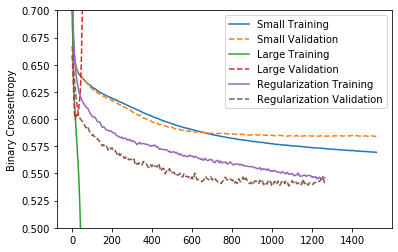

In [19]:
histSmall = pd.DataFrame(size_histories["small"].history)
histSmall['epoch'] = size_histories["small"].epoch

histLarge = pd.DataFrame(size_histories["large"].history)
histLarge['epoch'] = size_histories["large"].epoch

histReg = pd.DataFrame(size_histories["regularization"].history)
histReg['epoch'] = size_histories["regularization"].epoch

trainSmoothSmall = gaussian_filter1d(histSmall['binary_crossentropy'], sigma=3)
testSmoothSmall = gaussian_filter1d(histSmall['val_binary_crossentropy'], sigma=3)

trainSmoothLarge = gaussian_filter1d(histLarge['binary_crossentropy'], sigma=3)
testSmoothLarge = gaussian_filter1d(histLarge['val_binary_crossentropy'], sigma=3)

trainSmoothReg = gaussian_filter1d(histReg['binary_crossentropy'], sigma=3)
testSmoothReg = gaussian_filter1d(histReg['val_binary_crossentropy'], sigma=3)

plt.plot(histSmall['epoch'], trainSmoothSmall, '-', histSmall['epoch'], testSmoothSmall, '--')
plt.plot(histLarge['epoch'], trainSmoothLarge, '-', histLarge['epoch'], testSmoothLarge, '--')
plt.plot(histReg['epoch'], trainSmoothReg, '-', histReg['epoch'], testSmoothReg, '--',)
plt.ylim([0.5, 0.7])
plt.ylabel('Binary Crossentropy')
plt.legend(["Small Training", "Small Validation", "Large Training", "Large Validation", "Regularization Training", "Regularization Validation"])

    g) Compare three models accuracy trend over epochs

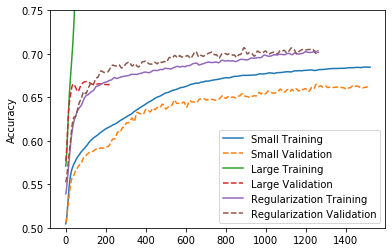

In [20]:
trainSmoothSmall = gaussian_filter1d(histSmall['accuracy'], sigma=6)
testSmoothSmall = gaussian_filter1d(histSmall['val_accuracy'], sigma=6)

trainSmoothLarge = gaussian_filter1d(histLarge['accuracy'], sigma=6)
testSmoothLarge = gaussian_filter1d(histLarge['val_accuracy'], sigma=6)

trainSmoothReg = gaussian_filter1d(histReg['accuracy'], sigma=6)
testSmoothReg = gaussian_filter1d(histReg['val_accuracy'], sigma=6)

plt.plot(histSmall['epoch'], trainSmoothSmall, '-', histSmall['epoch'], testSmoothSmall, '--')
plt.plot(histLarge['epoch'], trainSmoothLarge, '-', histLarge['epoch'], testSmoothLarge, '--')
plt.plot(histReg['epoch'], trainSmoothReg, '-', histReg['epoch'], testSmoothReg, '--',)

plt.ylim([0.5, 0.75])
plt.ylabel('Accuracy')
plt.legend(["Small Training", "Small Validation", "Large Training", "Large Validation","Regularization Training", "Regularization Validation",])